In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [107]:
p_values = pd.read_csv("IV_test_results/p_values_using_true_signals.csv", index_col=0)

In [108]:
new_col_names = ["seed"]
new_col_names.append("confounder_source")
for x in range(2,p_values.shape[1]-2):
    new_col_names.append(f"control_source_{x-1}")
new_col_names.append("treatment_source")
new_col_names.append("outcome_source")

In [109]:
p_values.columns = new_col_names

In [110]:
p_values.columns

Index(['seed', 'confounder_source', 'control_source_1', 'control_source_2',
       'control_source_3', 'treatment_source', 'outcome_source'],
      dtype='object')

In [111]:
long_df = p_values.melt(id_vars="seed")

In [112]:
long_df_subset = long_df.loc[long_df["variable"].isin(["confounder_source","control_source_1", "treatment_source"])]

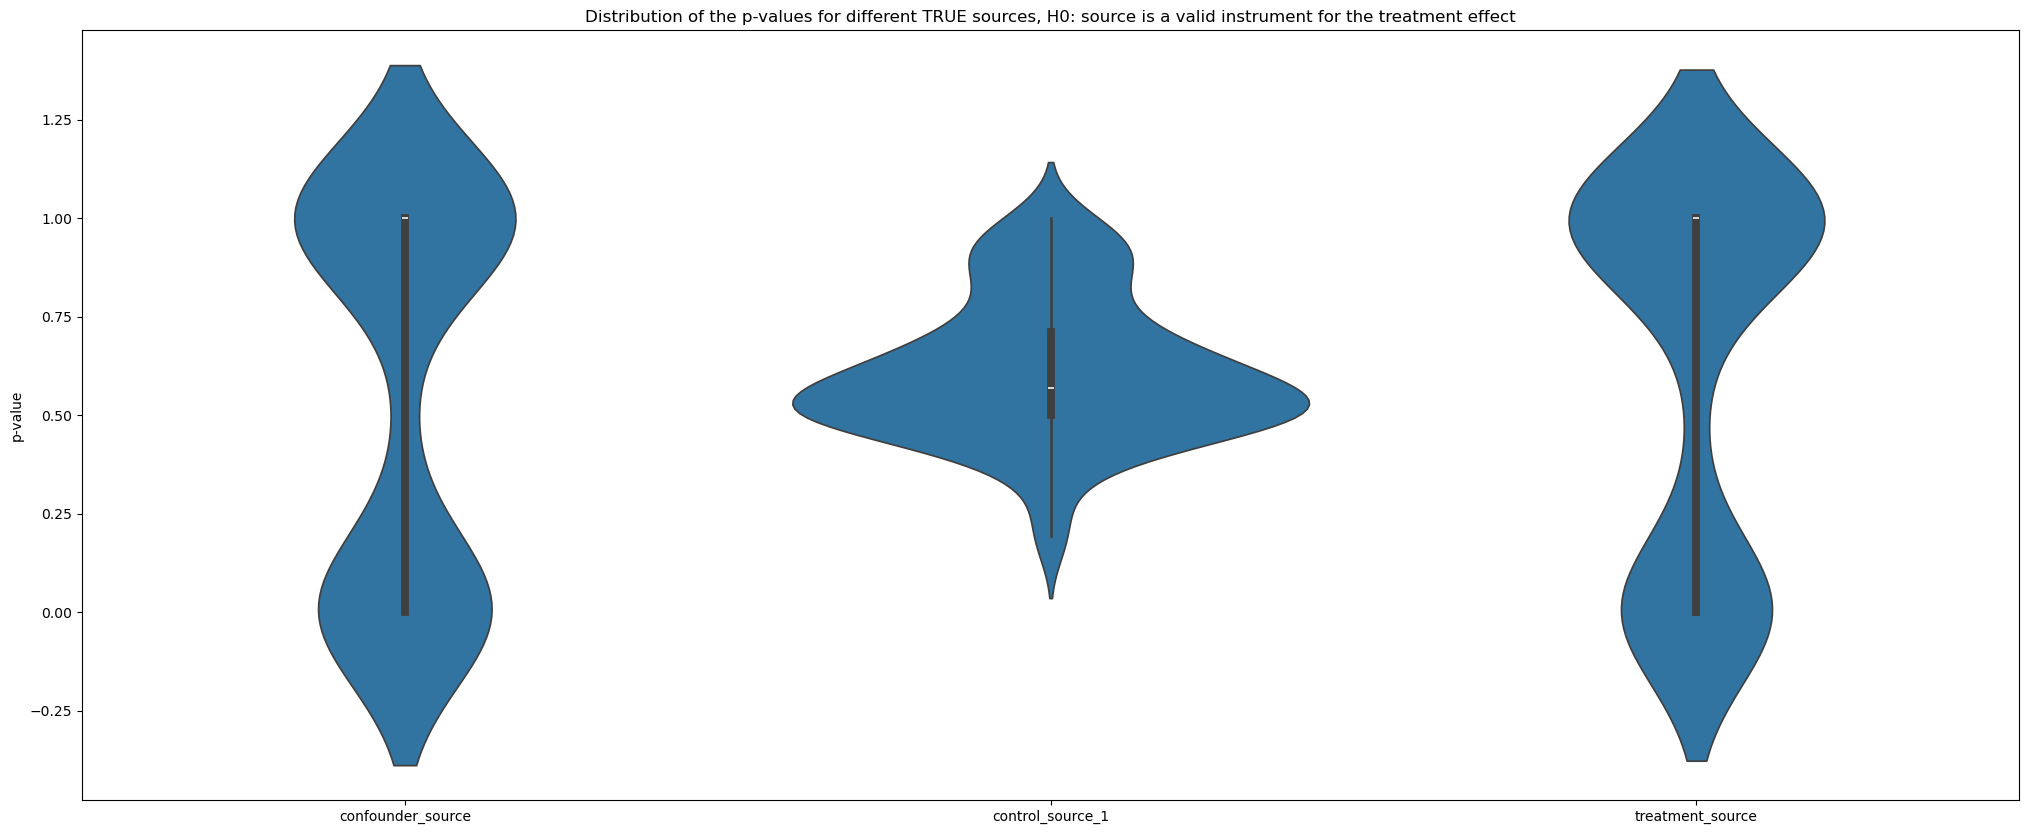

In [113]:
plt.figure(figsize= (25,10))
plt.title("Distribution of the p-values for different TRUE sources, H0: source is a valid instrument for the treatment effect")
sns.violinplot(long_df_subset, x = "variable", y = "value", inner = "box")
plt.xlabel("")
plt.ylabel("p-value")
plt.show()

In [6]:
df = np.round(pd.read_csv("sim_data/mixing_matrix/true_mixing_0.csv", header=0),2)

In [7]:
df

,0,1,2,3,4,5
0,0.00,1.00,-0.00,0.00,-0.00,-0.0
1,0.00,2.55,1.00,0.00,-0.00,-0.0
2,-0.00,2.22,-0.00,1.00,-0.00,0.0
3,-2.29,-5.46,-2.14,0.00,1.00,-0.0
4,5.20,17.66,5.92,0.41,-2.89,1.0


In [19]:
class dgp():
    def __init__(self, noise_dict = {"loc" : 0, "scale" : 0}, prior = False):
        if prior:
            self.loc = prior['loc']
            self.scale = prior['scale']
        else:
            self.loc = 0
            self.scale = 1/np.sqrt(2)
        self.noise = noise_dict

    def generate_data(self, n: int, I: int, J: int, random_state: int = 0, init_range = [-3,3]):
        np.random.seed(random_state)
        self.no_controls = J - 3
        self._generate_dag(J)
        self._generate_coefficients_matrix(J, init_range = init_range)
        self._generate_signals(n, J)

        self._generate_mixing_matrix()

        # generate data
        self.data = np.zeros((n, J))
        self.signals = np.zeros((n, J))


        self.signals[:, 0] = self.signal_U
        if self.no_controls > 0:
            self.signals[:, 1:(self.no_controls+1)] = self.signal_X
        self.signals[:, J-2] = self.signal_T
        self.signals[:, J-1] = self.signal_Y

        for j in range(J):
            self.data[:, j] = self.mixing_matrix[j, :] @ self.signals.T

        if self.noise:
            self.data += np.random.normal(loc=self.noise['loc'], scale=self.noise["scale"], size=(n, J))
        
        self.treatment_effect = self.coef_mat[-1, J-2]        # observed data is missing the confounder
        self.mixing_matrix_observed = self.mixing_matrix[1:J, :]
        self.data_observed = self.data[:, 1:J]
    
    def _generate_dag(self, J: int):
        self.adj_matrx = np.zeros((J, J)) # adjacency matrix at least 3 nodes
        # TODO: make this more general and allow for edges between controls 

        # w.l.o.g. we can assume that the matrix is in topological order meaning the confounder is the first node then controls then treatment (J-2) and outcome (J-1)
        self.adj_matrx[J-2,0] = 1 # confounder -> treatment
        self.adj_matrx[J-1,0] = 1 # confounder -> outcome
        self.adj_matrx[J-1,J-2] = 1 # treatment -> outcome

        
        if self.no_controls > 0:
            for i in range(1,(self.no_controls+1)):
                self.adj_matrx[J-1, i] = 1
            self.adj_matrx[J-2, 2] = 1 # control2 -> treatment

        self.adj_matrx[2,1] = 1 # control1 -> control
        if self.no_controls > 2:
            self.adj_matrx[3,1] = 1 # control1 -> control3
        



    def _generate_coefficients_matrix(self, J: int, init_range = [-3,3]):
        coef_of_edges = np.random.uniform(low=init_range[0], high=init_range[1], size=(J, J))
        self.coef_mat = np.multiply(self.adj_matrx, coef_of_edges) 

    def _generate_signals(self, n: int, J):
        self.signal_T = np.random.laplace(loc=self.loc, scale=self.scale, size=n)
        self.signal_Y = np.random.laplace(loc=self.loc, scale=self.scale, size=n)
        self.signal_U = np.random.laplace(loc=self.loc, scale=self.scale, size=n)
        if self.no_controls > 0:
            self.signal_X = np.random.laplace(loc=self.loc, scale=self.scale, size=(n, self.no_controls))

    def _generate_mixing_matrix(self):
        # by construction, the noise has coefficient 1 for its own node
        I = np.eye(self.coef_mat.shape[0])  # Identity matrix of size J
        self.mixing_matrix =  np.linalg.inv(I - self.coef_mat)



In [20]:
dat = dgp()
dat.generate_data(1,5,6,random_state=0)

In [21]:
dat.adj_matrx

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.]])